# IEOR4571 Final Project: Deep Learning Model



Team members: Diyue Gu (dg3198), Jingyan Xu (jx2424), Yifei Zhang (yz3925), Chelsea Cui (ac4788), Yishi Wang (yw3619)


## Model Design

Deep Learning is a powerful tool for recommendation especially when there's large amount of data learnable. With less feature engineering, deep learning can learn representations (through learinng with embedding layers) of features in a more efficient and flexible way. In this notebook, we present a deep learning solution which could be used for experienced users who have relatively more ratings.


General Procedures:
1. Inputs of the model include a movie ID and a user ID
2. We embed the ids into vectors of size 1 * n_factors (n_factors of 30 was found as the best size)
3. The learned embedded layers are combined and condensed with dense layers
4. Finally, the output is a predicted rating that the user would give to the movie


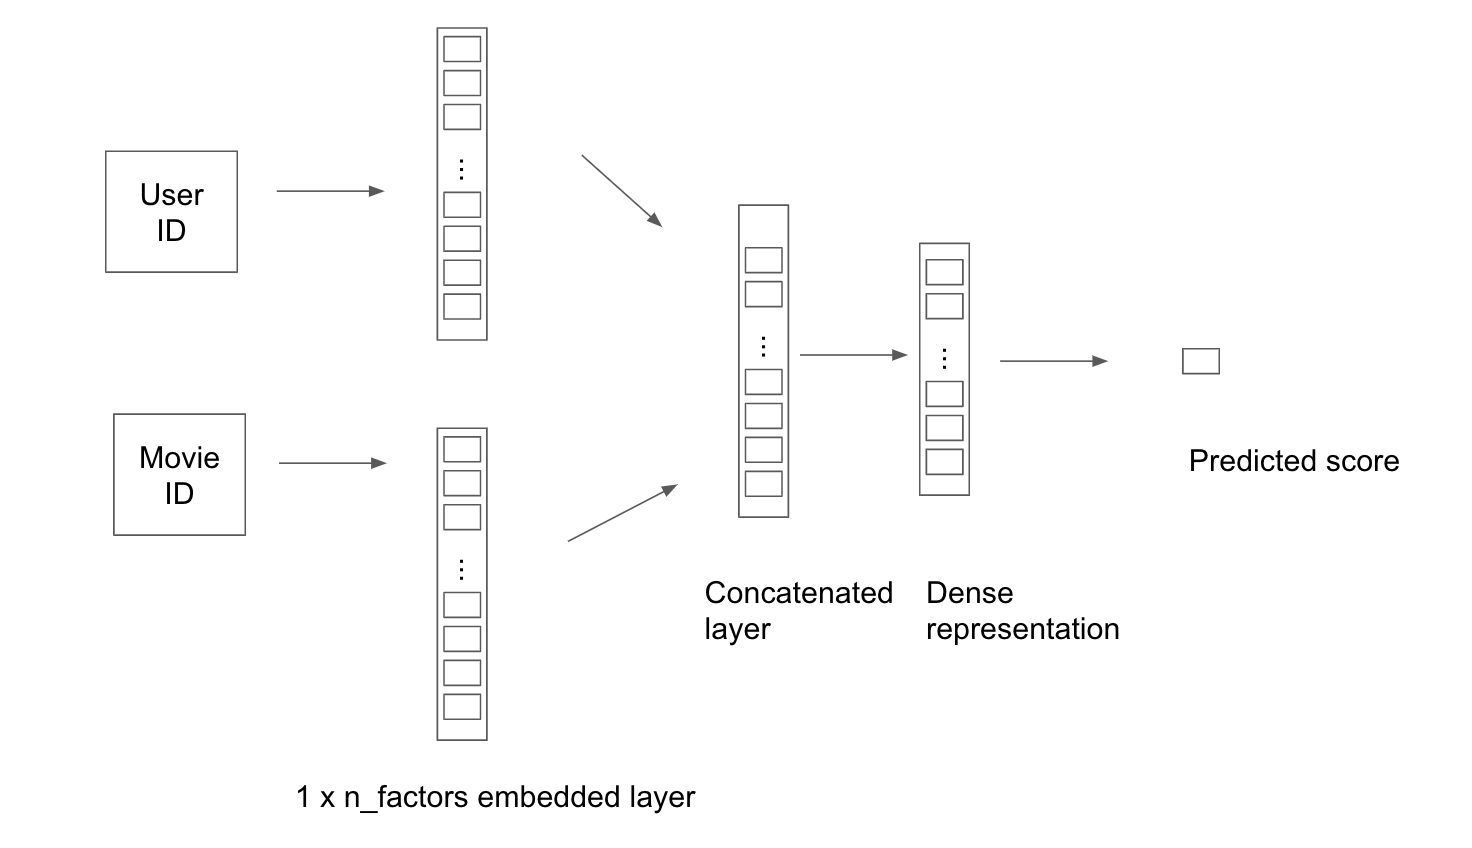

## Implementation

### Import Data and Libraries

We first imported the packages and libraries needed.

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf

from math import sqrt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers import Input, Reshape, Dot, Add, Activation, Lambda, Concatenate, Dense, Dropout, Embedding
from tensorflow.keras.models import Model, Sequential


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "drive/MyDrive/4571/final"

Mounted at /content/drive
/content/drive/MyDrive/Chelsea/F20/4571/final


The train and test set has been pre-sampled by the preprocessing notebook.

In [ ]:
# Load training set
all_data = pd.read_csv('train.csv')

# Load test set for different cases
test_data_dl = pd.read_csv('test_for_dp.csv')
test_data_cb = pd.read_csv('test_for_content.csv')
test_data_mb = pd.read_csv('test_for_mf.csv')

### Model

In [ ]:
# Embeeding helper function
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=tf.keras.regularizers.L2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x


In [ ]:
# Deep Learning Model
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating,
                   lr = 0.001):

    # Get embeeding for user id
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    # Get embeeding for movie id
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    # Make prediction and rescaling
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)

    model.compile(loss='mean_squared_error', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In order to save computation time and space for the hybrid model, we created this integrated function to pre-train the model and get a pre-evaluation csv, which has been saved to the same folder. The data was used for the hybrid model.

However, this is just for time saving. The hybrid model could also call this function with new training and test sets in the file if more computation power is given.

In [ ]:
# Inputs:
# - train_data: training data set
# - test_data: test data set
# - top_n: top n recommendations we want to get
# - n_factors = length of the user and movie id encoding

# Output:
# - recommend: a dataframe which includes the top_n movie ids for each user and the corresponding predicted score (for evaluation)

def dl_train(train_data, test_data,  top_n, n_factor = 30):

    # Data preparation and encoding
    all_data = pd.concat([train_data,test_data])

    user_enc = LabelEncoder().fit(all_data['userId'].values)
    all_data['userId'] = user_enc.transform(all_data['userId'].values)
    n_users = all_data['userId'].nunique()

    item_enc = LabelEncoder().fit(all_data['movieId'].values)
    all_data['movieId'] = item_enc.transform(all_data['movieId'].values)
    n_movies = all_data['movieId'].nunique()

    all_data['rating'] = all_data['rating'].values.astype(np.float32)
    train_data['rating'] = train_data['rating'].values.astype(np.float32)
    test_data['rating'] = test_data['rating'].values.astype(np.float32)

    min_rating = min(all_data['rating'])
    max_rating = max(all_data['rating'])

    train_data['userId_orig']  = train_data['userId']
    train_data['movieId_orig']  = train_data['movieId']
    
    test_data['userId_orig'] = test_data['userId']
    test_data['movieId_orig'] = test_data['movieId']

    train_data['userId'] = user_enc.transform(train_data['userId'].values)
    train_data['movieId'] = item_enc.transform(train_data['movieId'].values)

    test_data['userId'] = user_enc.transform(test_data['userId'].values)
    test_data['movieId'] = item_enc.transform(test_data['movieId'].values)

    test_movie_id_dict = dict()
    test_user_id_dict = dict()

    test_encodded_mid_list = test_data['movieId'].tolist()
    test_encodded_uid_list = test_data['userId'].tolist()
    test_mid_list = test_data['movieId_orig'].tolist()
    test_uid_list = test_data['userId_orig'].tolist()

    for i,mid in enumerate(test_encodded_mid_list):
      test_movie_id_dict[mid] =  test_mid_list[i]

    for j,uid in enumerate(test_encodded_uid_list):
      test_user_id_dict[uid] =  test_uid_list[j]

    # Adjust train and test set format for DL model
    X_train_array = [train_data.iloc[:,0], train_data.iloc[:,1]]
    X_test_array = [test_data.iloc[:,0], test_data.iloc[:,1]]

    y_train = train_data.iloc[:,2]
    y_test = test_data.iloc[:,2]  

    # Define and train model
    model = RecommenderNet(n_users, n_movies, n_factor, min_rating, max_rating)
    model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=10,
            verbose = False, validation_data=(X_test_array, y_test))
    
    # Generate predication
    preds = model.predict(X_test_array)
    combined = test_data.copy()
    combined["pred"] = preds
    

    # Recommendation reformatting
    recommend = pd.DataFrame(data = None, columns = ['userId', 'Recommendation']) 
    for uid in test_data.userId.unique():
        selected = combined[combined["userId"] == uid]
        selected = selected.sort_values(by="pred", ascending=False)
        uid_recommendation = []
        uid_movieIds = selected["movieId"].tolist()[:top_n]
        uid_preds = selected["pred"].tolist()[:top_n]
        for i in range(min(top_n,len(selected))):
          uid_recommendation.append((test_movie_id_dict[uid_movieIds[i]],uid_preds[i]))

        new_row = {'userId': test_user_id_dict[uid], 'Recommendation': uid_recommendation}
        recommend = recommend.append(new_row, ignore_index=True)


    return recommend
  

The following code was used for pre-train the model for the hybrid system. Commented to save running time.

In [ ]:
dl_train_set = all_data.loc[:,["userId","movieId","rating"]]
dl_test_set = test_data_dl.loc[:,["userId","movieId","rating"]]

In [ ]:
# DLPreTrained = dl_train(dl_train_set, dl_test_set, 10, n_factor = 30)

In [ ]:
# DLPreTrained.to_csv('DL_recommend_df.csv')

## Evaluation

We started the evaluation by using hyperparameters of n_factor = 30 and learning rate  = 0.001

In [ ]:
train_data = dl_train_set
test_data = dl_test_set
n_factor = 30

In [ ]:
all_data = pd.concat([train_data,test_data])

user_enc = LabelEncoder().fit(all_data['userId'].values)
all_data['userId'] = user_enc.transform(all_data['userId'].values)
n_users = all_data['userId'].nunique()

item_enc = LabelEncoder().fit(all_data['movieId'].values)
all_data['movieId'] = item_enc.transform(all_data['movieId'].values)
n_movies = all_data['movieId'].nunique()

all_data['rating'] = all_data['rating'].values.astype(np.float32)
train_data['rating'] = train_data['rating'].values.astype(np.float32)
test_data['rating'] = test_data['rating'].values.astype(np.float32)

min_rating = min(all_data['rating'])
max_rating = max(all_data['rating'])

train_data['userId_orig']  = train_data['userId']
train_data['movieId_orig']  = train_data['movieId']

test_data['userId_orig'] = test_data['userId']
test_data['movieId_orig'] = test_data['movieId']

train_data['userId'] = user_enc.transform(train_data['userId'].values)
train_data['movieId'] = item_enc.transform(train_data['movieId'].values)

test_data['userId'] = user_enc.transform(test_data['userId'].values)
test_data['movieId'] = item_enc.transform(test_data['movieId'].values)

test_movie_id_dict = dict()
test_user_id_dict = dict()

test_encodded_mid_list = test_data['movieId'].tolist()
test_encodded_uid_list = test_data['userId'].tolist()
test_mid_list = test_data['movieId_orig'].tolist()
test_uid_list = test_data['userId_orig'].tolist()

for i,mid in enumerate(test_encodded_mid_list):
  test_movie_id_dict[mid] =  test_mid_list[i]

for j,uid in enumerate(test_encodded_uid_list):
  test_user_id_dict[uid] =  test_uid_list[j]

X_train_array = [train_data.iloc[:,0], train_data.iloc[:,1]]
X_test_array = [test_data.iloc[:,0], test_data.iloc[:,1]]

y_train = train_data.iloc[:,2]
y_test = test_data.iloc[:,2]  

model = RecommenderNet(n_users, n_movies, n_factor, min_rating, max_rating)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        600000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 30)        30000       input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
11216/11216 [==============================] - 75s 7ms/step - loss: 0.9130 - root_mean_squared_error: 0.9540 - val_loss: 0.7096 - val_root_mean_squared_error: 0.8403
Epoch 2/5
11216/11216 [==============================] - 71s 6ms/step - loss: 0.7803 - root_mean_squared_error: 0.8810 - val_loss: 0.7032 - val_root_mean_squared_error: 0.8349
Epoch 3/5
11216/11216 [==============================] - 70s 6ms/step - loss: 0.7694 - root_mean_squared_error: 0.8733 - val_loss: 0.7043 - val_root_mean_squared_error: 0.8344
Epoch 4/5
11216/11216 [==============================] - 69s 6ms/step - loss: 0.7646 - root_mean_squared_error: 0.8696 - val_loss: 0.6986 - val_root_mean_squared_error: 0.8303
Epoch 5/5
11216/11216 [==============================] - 68s 6ms/step - loss: 0.7602 - root_mean_squared_error: 0.8665 - val_loss: 0.6969 - val_root_mean_squared_error: 0.8288


In [ ]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['root_mean_squared_error']
  val_acc = history.history['val_root_mean_squared_error']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation Root mean squared error')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

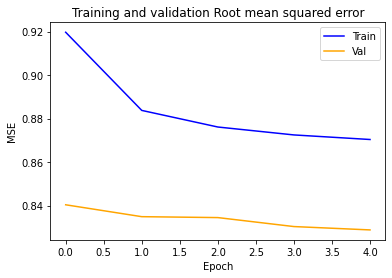

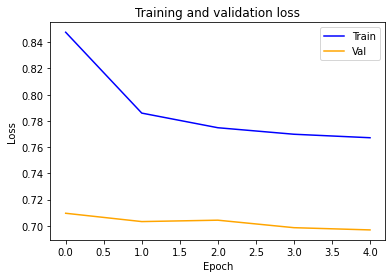

In [ ]:
plot(history)

By training the model for 5 epoches, the RMSE result achived a score that is pretty close to the other models and there's no overfitting problem at this point. If computation power allows, we would train the model with more epoches and the results should be much better. 

### Tuning Hyperparameter

In [ ]:
lr_candidate = [0.1,0.001]
factor_candidate = [10,20,30]

Epoch 1/5
11216/11216 [==============================] - 71s 6ms/step - loss: 1.2842 - root_mean_squared_error: 1.1091 - val_loss: 1.1769 - val_root_mean_squared_error: 1.0782
Epoch 2/5
11216/11216 [==============================] - 70s 6ms/step - loss: 1.1747 - root_mean_squared_error: 1.0793 - val_loss: 1.1452 - val_root_mean_squared_error: 1.0689
Epoch 3/5
11216/11216 [==============================] - 68s 6ms/step - loss: 1.1357 - root_mean_squared_error: 1.0643 - val_loss: 1.1449 - val_root_mean_squared_error: 1.0696
Epoch 4/5
11216/11216 [==============================] - 67s 6ms/step - loss: 1.1304 - root_mean_squared_error: 1.0626 - val_loss: 1.1094 - val_root_mean_squared_error: 1.0531
Epoch 5/5
11216/11216 [==============================] - 67s 6ms/step - loss: 1.1256 - root_mean_squared_error: 1.0609 - val_loss: 1.1064 - val_root_mean_squared_error: 1.0519
Current Learning Rate: 0.1 , Best Validation RMSE:  1.078151822090149


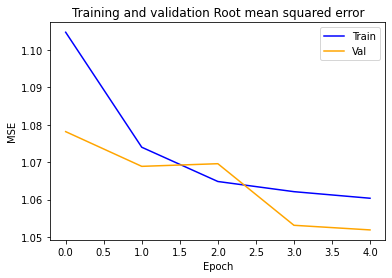

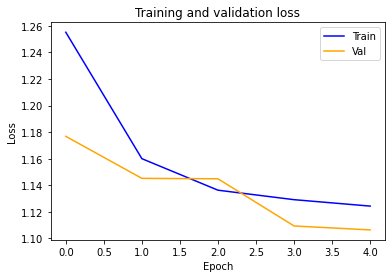

Epoch 1/5
11216/11216 [==============================] - 67s 6ms/step - loss: 0.9156 - root_mean_squared_error: 0.9553 - val_loss: 0.7087 - val_root_mean_squared_error: 0.8398
Epoch 2/5
11216/11216 [==============================] - 65s 6ms/step - loss: 0.7760 - root_mean_squared_error: 0.8785 - val_loss: 0.6997 - val_root_mean_squared_error: 0.8328
Epoch 3/5
11216/11216 [==============================] - 65s 6ms/step - loss: 0.7654 - root_mean_squared_error: 0.8710 - val_loss: 0.7006 - val_root_mean_squared_error: 0.8324
Epoch 4/5
11216/11216 [==============================] - 66s 6ms/step - loss: 0.7579 - root_mean_squared_error: 0.8659 - val_loss: 0.6977 - val_root_mean_squared_error: 0.8300
Epoch 5/5
11216/11216 [==============================] - 66s 6ms/step - loss: 0.7571 - root_mean_squared_error: 0.8649 - val_loss: 0.6942 - val_root_mean_squared_error: 0.8274
Current Learning Rate: 0.001 , Best Validation RMSE:  0.8398191332817078


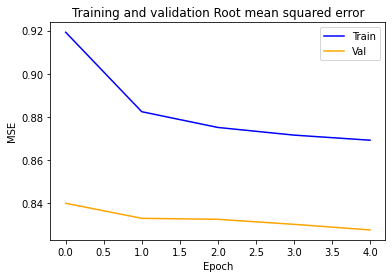

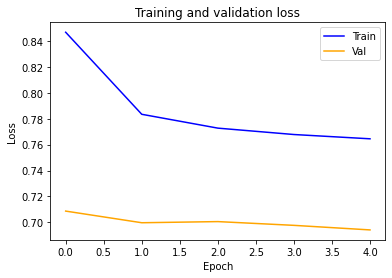

In [ ]:
for lr in lr_candidate:
  model = RecommenderNet(n_users, n_movies, n_factor, min_rating, max_rating, lr=lr)
  history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))
  print("Current Learning Rate:",lr,", Best Validation RMSE: ", min(history.history['val_root_mean_squared_error']))
  plot(history)
  plt.show()

Epoch 1/5
11216/11216 [==============================] - 49s 4ms/step - loss: 0.9283 - root_mean_squared_error: 0.9620 - val_loss: 0.7108 - val_root_mean_squared_error: 0.8422
Epoch 2/5
11216/11216 [==============================] - 48s 4ms/step - loss: 0.7810 - root_mean_squared_error: 0.8827 - val_loss: 0.6968 - val_root_mean_squared_error: 0.8330
Epoch 3/5
11216/11216 [==============================] - 48s 4ms/step - loss: 0.7651 - root_mean_squared_error: 0.8728 - val_loss: 0.6969 - val_root_mean_squared_error: 0.8321
Epoch 4/5
11216/11216 [==============================] - 49s 4ms/step - loss: 0.7555 - root_mean_squared_error: 0.8665 - val_loss: 0.6929 - val_root_mean_squared_error: 0.8290
Epoch 5/5
11216/11216 [==============================] - 50s 4ms/step - loss: 0.7541 - root_mean_squared_error: 0.8650 - val_loss: 0.6932 - val_root_mean_squared_error: 0.8287
Current Learning Rate: 0.001 , Best Validation RMSE:  0.8287255167961121


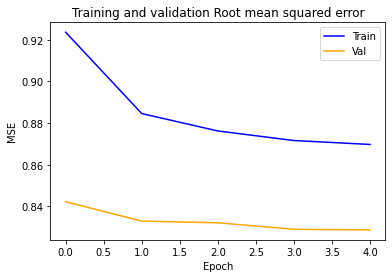

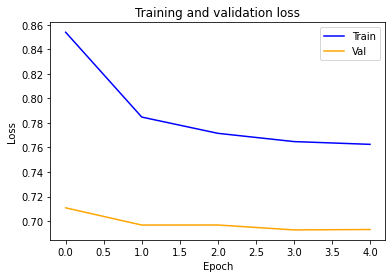

Epoch 1/5
11216/11216 [==============================] - 60s 5ms/step - loss: 0.9126 - root_mean_squared_error: 0.9540 - val_loss: 0.7126 - val_root_mean_squared_error: 0.8427
Epoch 2/5
11216/11216 [==============================] - 59s 5ms/step - loss: 0.7834 - root_mean_squared_error: 0.8833 - val_loss: 0.7036 - val_root_mean_squared_error: 0.8361
Epoch 3/5
11216/11216 [==============================] - 59s 5ms/step - loss: 0.7716 - root_mean_squared_error: 0.8755 - val_loss: 0.6997 - val_root_mean_squared_error: 0.8327
Epoch 4/5
11216/11216 [==============================] - 59s 5ms/step - loss: 0.7648 - root_mean_squared_error: 0.8707 - val_loss: 0.6986 - val_root_mean_squared_error: 0.8313
Epoch 5/5
11216/11216 [==============================] - 60s 5ms/step - loss: 0.7625 - root_mean_squared_error: 0.8688 - val_loss: 0.6997 - val_root_mean_squared_error: 0.8315
Current Learning Rate: 0.001 , Best Validation RMSE:  0.8313297033309937


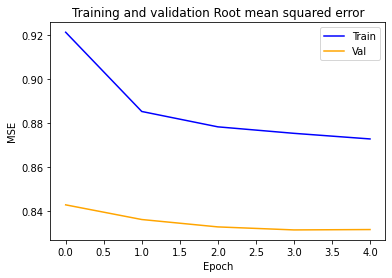

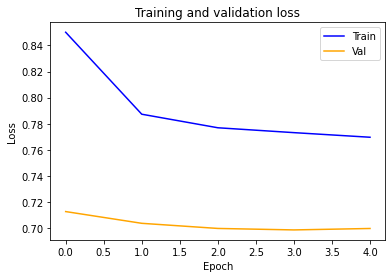

Epoch 1/5
11216/11216 [==============================] - 71s 6ms/step - loss: 0.9103 - root_mean_squared_error: 0.9526 - val_loss: 0.7076 - val_root_mean_squared_error: 0.8391
Epoch 2/5
11216/11216 [==============================] - 69s 6ms/step - loss: 0.7771 - root_mean_squared_error: 0.8791 - val_loss: 0.7058 - val_root_mean_squared_error: 0.8363
Epoch 3/5
11216/11216 [==============================] - 70s 6ms/step - loss: 0.7687 - root_mean_squared_error: 0.8728 - val_loss: 0.7016 - val_root_mean_squared_error: 0.8327
Epoch 4/5
11216/11216 [==============================] - 70s 6ms/step - loss: 0.7628 - root_mean_squared_error: 0.8684 - val_loss: 0.6986 - val_root_mean_squared_error: 0.8302
Epoch 5/5
11216/11216 [==============================] - 71s 6ms/step - loss: 0.7590 - root_mean_squared_error: 0.8656 - val_loss: 0.7003 - val_root_mean_squared_error: 0.8307
Current Learning Rate: 0.001 , Best Validation RMSE:  0.8301648497581482


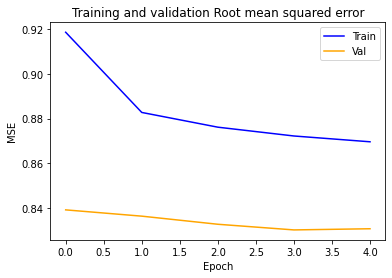

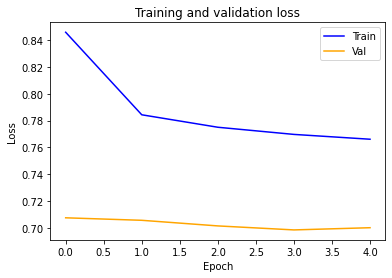

In [ ]:
for fac in factor_candidate:
  model = RecommenderNet(n_users, n_movies, fac, min_rating, max_rating)
  history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))
  print("Current Learning Rate:",lr,", Best Validation RMSE: ", min(history.history['val_root_mean_squared_error']))
  plot(history)
  plt.show()

By tuning learning rate and embedding layer length, we achived the following results:

| Learning Rate     | Validation RMSE |
| ----------- | ----------- |
| 0.01      | 1.0519      |
| 0.001   | 0.8274        |

| Embedding Length     | Validation RMSE |
| ----------- | ----------- |
| 10     | 0.8287      |
| 20   | 0.8315        |
| 30   | 0.8302        |

From the tables above, we can see that learning rate of 0.001 performs much better than 0.01, so we will use 0.001 in our model. However, there's no significant change in RMSE regarding the embedding length used.

## Conclusion

In conclusion, based on the single model evaluation results above, deep learning is a pretty strong solution to make recommendations for users with many history data. 

We also compared the deep learning model with other models by using more complex metrics in the Hybrid Model notebook.

### Further Steps

If more computation power provided, Deep learning is a high potential model that could be improved in the future in the ways below:

1. Add more embedding layers for movie information, like movie title or tags.
2. Use wide and deep network to learning more complex embeddings.
3. Add time sensitivity to model by using sequential techniques like LSTM.